## ANALYSIS EXPERIMENT 2.1 (gpt2-xl vs GPT2 small)

Comparison of GPT2 small and GPT2XL: To obtain the same effect on GPT2XL; one has to increase the number of neurons by 10

GPT-small experiments:
```
'../experiments/gpt2-small/experiment_2_1/results/'
filename = 'experiment_2_1_with_B_20240720_011953.json' => Threshold_list_small 
```

GPT2-XL Experiments
```

- 20k to 200k Best LR (lr1e-5): experiment_2_1_20240717_115823.json  => experiment_2_1_with_B_20240911_181551_bestLR_10XNeurons.json => Threshold_list_large
- 2k to 20k Best LR (lr1e-5): experiment_2_1_20240716_114247.json => experiment_2_1_with_B_20240913_013018_bestLR.json +> Threshold_list_small
- 2k to 20k 10 times best LR (lr1e-4): experiment_2_1_with_B_20240912_203810_10xLR.json => Threshold_list_small 
- 2k to 20k => 50 epochs => experiment_2_1_with_B_20240912_150705epochs50s.json => Threshold_list_small 
- 2k to 20k => same LR as GPT2small 1e-3 => experiment_2_1_with_B_20240911_135230_sameLRassmall.json  => Threshold_list_small 
```

Threshold_list_small = [2000,8000,12000,16000,20000]
Threshold_list_large = [20000, 80000, 120000, 160000, 200000]



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Plotting All Experiments Together...


Plotting Two Selected Experiments...


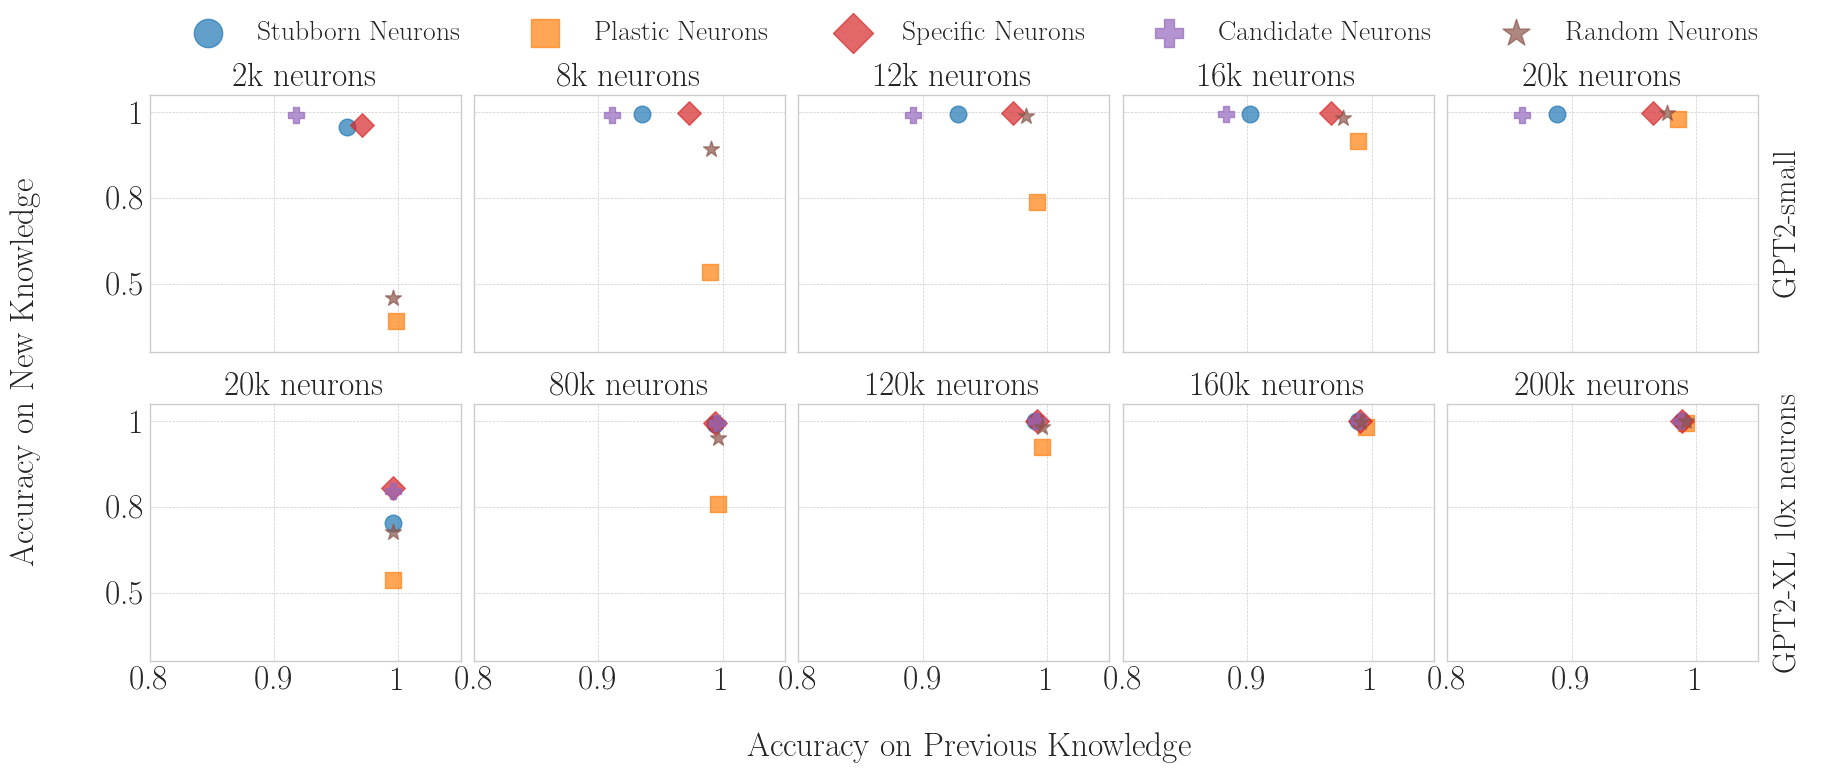

Plotting Two Selected Experiments...


Plotting Two Selected Experiments...


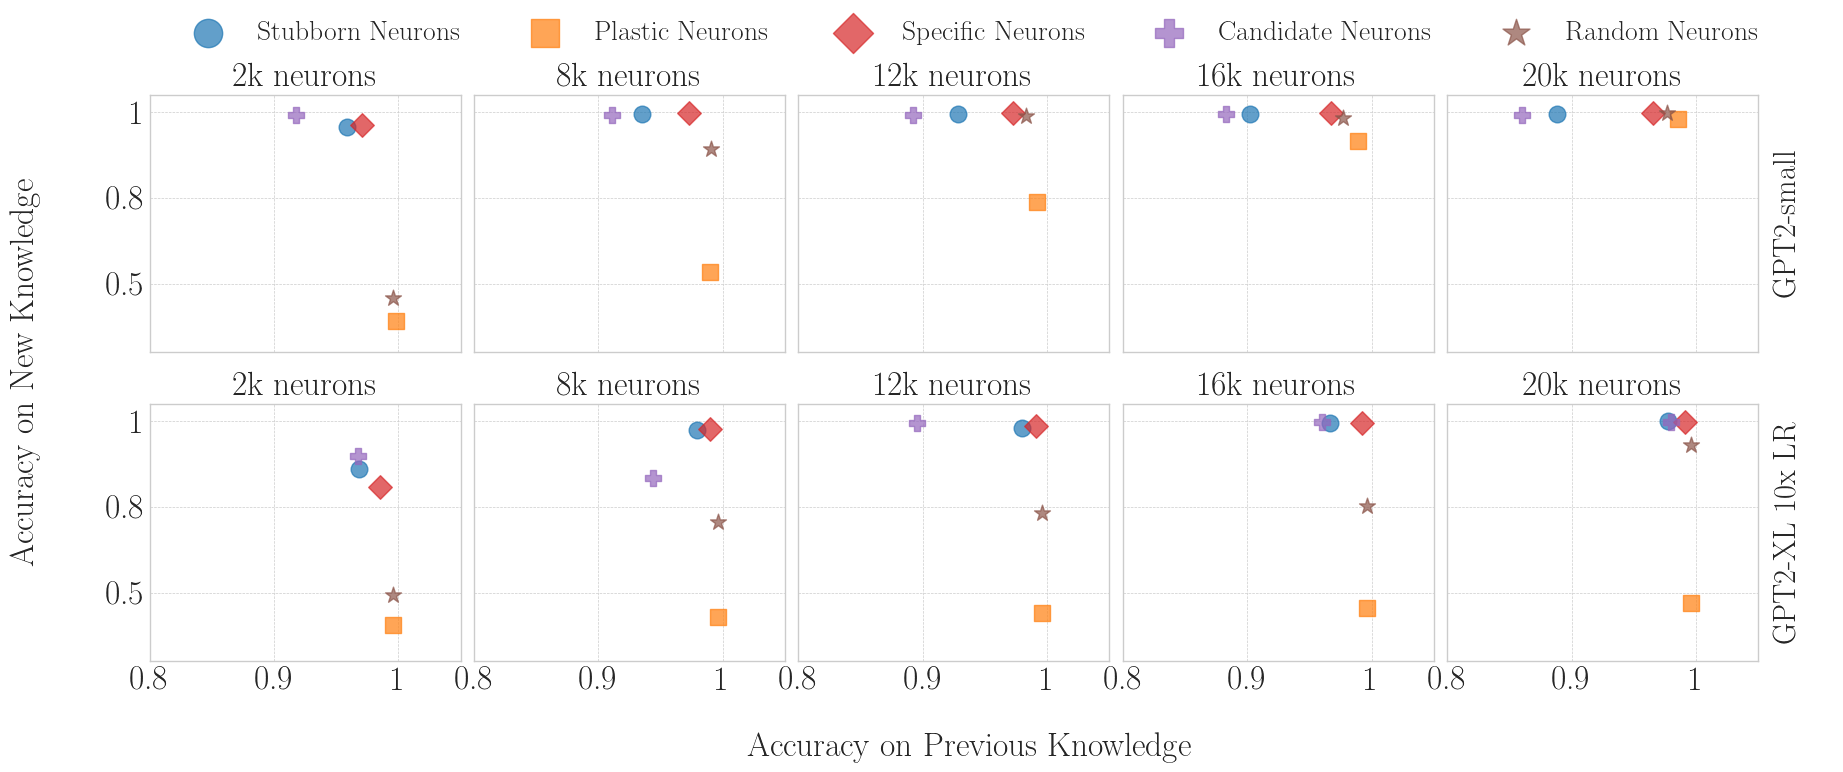

Plotting Two Selected Experiments...


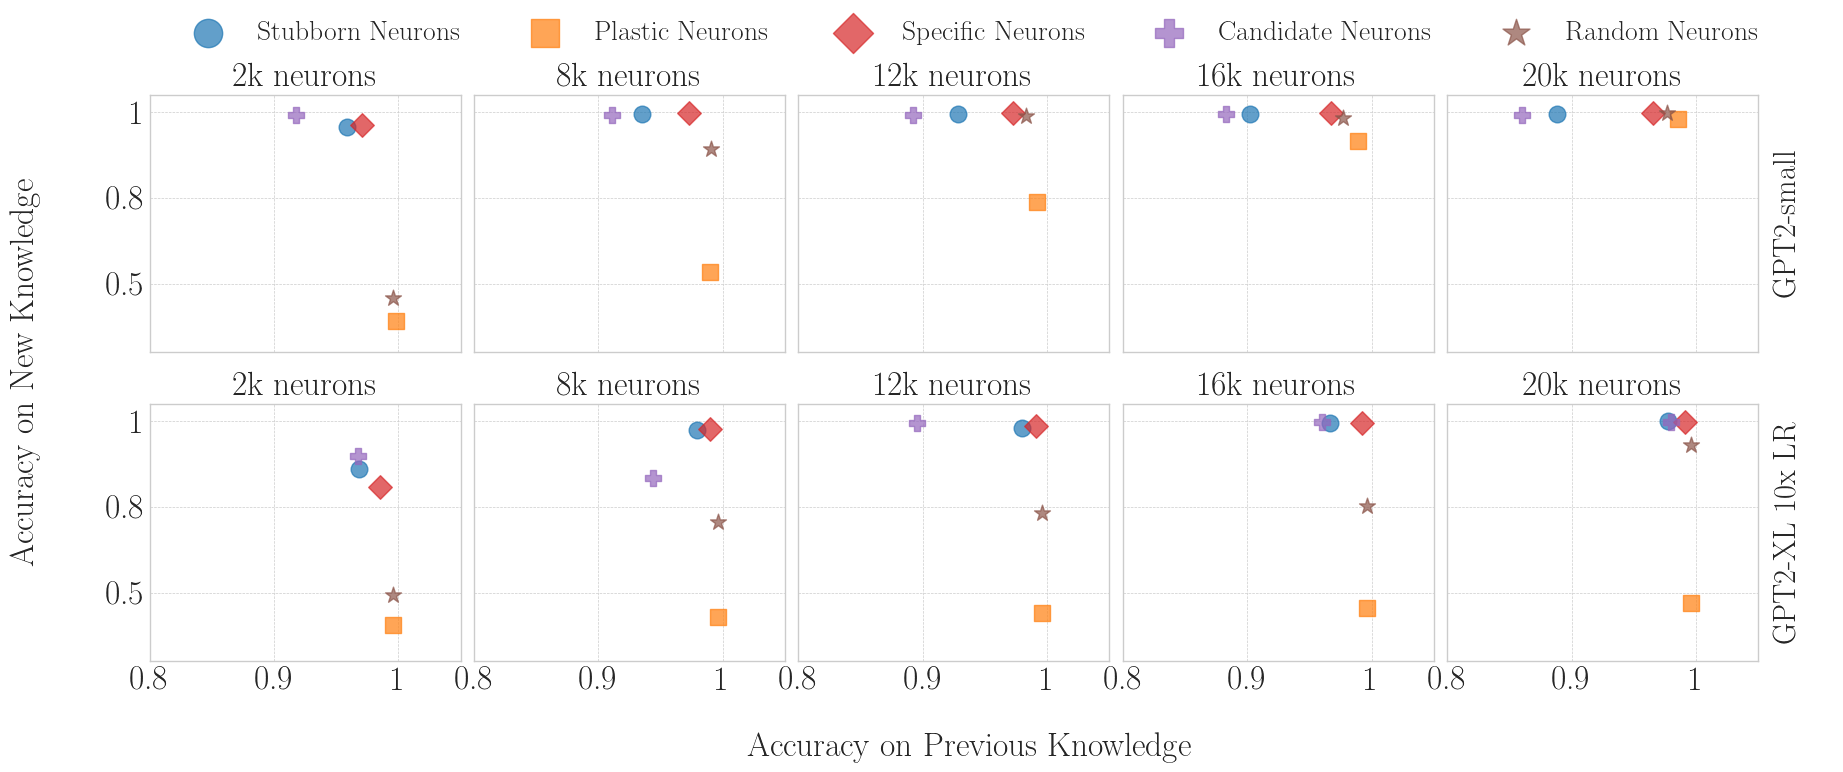

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import json

def plot_pareto_mosaic_multi(file_list, experiment_names, thresholds_list, strategy_map, strategies=None, figsize=None, set_axis_limits=True, x_limits=(-0.05, 1.05), y_limits=(-0.05, 1.05)):
    """
    Plots multiple Pareto scatter plots arranged in a mosaic with 5 plots per row.
    Each row corresponds to one experiment, and a title is added to the right of each row.

    Parameters:
    - file_list: list of tuples (filepath, filename)
    - experiment_names: list of strings, names for each experiment
    - thresholds_list: list of lists, each inner list contains thresholds for the corresponding file
    - strategy_map: dict, mapping strategies to their plot properties
    - strategies: list of strategies to plot (optional)
    - figsize: tuple, figure size (optional). If None, it will be set based on the number of rows.
    - set_axis_limits: bool, if True, sets x and y limits to x_limits y_limits for all subplots
    """

    # Calculate the number of experiments
    N_files = len(file_list)
    n_cols = 5  # Fixed number of columns (5 plots per row)

    # Dynamic Figure Sizing
    if figsize is None:
        fig_width = 20  # Increased width to accommodate experiment names
        height_per_row = 4  # 5 inches per row
        fig_height = height_per_row * N_files
        figsize = (fig_width, fig_height)
    else:
        fig_width, fig_height = figsize

    # Set the matplotlib settings
    plt.style.use('seaborn-whitegrid')
    plt.rcParams.update({
        'font.size': 24,
        'axes.labelsize': 12,
        'axes.titlesize': 24,
        'xtick.labelsize': 24,
        'ytick.labelsize': 24,
        'legend.fontsize': 26,
        'font.family': 'serif',
        'text.usetex': True,
    })
    from matplotlib.ticker import FuncFormatter
    def format_neurons(neurons):
        """Format neuron counts to '2k neurons', '20k neurons', etc."""
        if neurons >= 1000:
            return f'{int(neurons / 1000)}k neurons'
        else:
            return f'{neurons} neurons'

    def tick_formatter(x, pos):
        if x == 0:
            return "0"
        elif x == 1:
            return "1"
        else:
            return f"{x:.1f}"
    # Create figure
    fig = plt.figure(figsize=figsize)

    # Create GridSpec
    gs = gridspec.GridSpec(N_files, n_cols + 1, width_ratios=[1, 1, 1, 1, 1, 0.2])

    if strategies is None:
        strategies = ['busy_A', 'free_A', 'spec_B', 'busy_B', 'rnd']  # Default strategies

    # Initialize lists to collect legend handles and labels
    legend_handles = []
    legend_labels = []

    # Loop through each file/experiment
    for row_idx, ((filepath, filename), experiment_name, thresholds) in enumerate(zip(file_list, experiment_names, thresholds_list)):
        # Load data
        data_path = os.path.join(filepath, filename)
        if not os.path.exists(data_path):
            print(f"Warning: File {data_path} does not exist. Skipping this experiment.")
            continue

        with open(data_path, 'r') as file:
            data = json.load(file)

        # Initialize results dictionary
        results = {strategy: {'acc_A': [], 'acc_B': []} for strategy in strategies}

        # Aggregate results across folds
        for fold in data['results'].values():
            for strategy in strategies:
                acc_A = []
                acc_B = []
                for t in thresholds:
                    t_str = str(t)
                    try:
                        acc_A.append(fold['cftb'][t_str][strategy]['avg_accA'])
                        acc_B.append(fold['cftb'][t_str][strategy]['avg_accB'])
                    except KeyError:
                        print(f"Warning: Missing data for threshold {t} or strategy {strategy} in file {filename}.")
                        acc_A.append(np.nan)
                        acc_B.append(np.nan)
                results[strategy]['acc_A'].append(acc_A)
                results[strategy]['acc_B'].append(acc_B)

        # Compute means for each strategy
        for strategy in strategies:
            acc_A_array = np.array(results[strategy]['acc_A'], dtype=np.float64)
            acc_B_array = np.array(results[strategy]['acc_B'], dtype=np.float64)
            results[strategy]['mean_acc_A'] = np.nanmean(acc_A_array, axis=0)
            results[strategy]['mean_acc_B'] = np.nanmean(acc_B_array, axis=0)

        # Plot scatter for each strategy in the row's subplots (1 row per experiment)
        for col_idx, neurons in enumerate(thresholds):
            ax = fig.add_subplot(gs[row_idx, col_idx])

            for strategy in strategies:
                label = strategy_map[strategy]['label']
                color = strategy_map[strategy]['color']
                marker = strategy_map[strategy]['marker']
                scatter = ax.scatter(
                    results[strategy]['mean_acc_A'][col_idx],
                    results[strategy]['mean_acc_B'][col_idx],
                    label=label,
                    color=color,
                    s=144,
                    alpha=0.7,
                    marker=marker
                )
                if row_idx == 0 and col_idx == 0:  # Only add legend info once
                    legend_handles.append(scatter)
                    legend_labels.append(label)

            # Set subplot title with neuron counts formatted as "2k neurons", etc.
            ax.set_title(f'{format_neurons(neurons)}')

            ax.grid(True, linestyle='--', linewidth=0.5)


            ax.xaxis.set_major_formatter(FuncFormatter(tick_formatter))
            ax.yaxis.set_major_formatter(FuncFormatter(tick_formatter))
            # Set x and y limits if set_axis_limits is True
            if set_axis_limits:
            # Set specific ticks for x and y axes
                ax.set_xlim(*x_limits)
                ax.set_ylim(*y_limits)
                #ax.set_xticks([0, 0.5, 1])
                #ax.set_yticks([0, 0.5, 1])
                # Selectively apply tick parameters
                if col_idx == 0:  # Leftmost column
                    ax.tick_params(axis='y', which='both', left=True, labelleft=True)
                else:
                    ax.tick_params(axis='y', which='both', left=False, labelleft=False)
                ax.tick_params(axis='x', which='both', bottom=True, labelbottom=True)
                if row_idx == len(file_list) - 1:  # Bottom row
                    ax.tick_params(axis='x', which='both', bottom=True, labelbottom=True)
                else:
                    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
            else:
                pass
                # if col_idx == 0:  # Leftmost column
                #     ax.tick_params(axis='y', which='both', left=True, labelleft=True)
                #     ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
                # else:
                #     ax.tick_params(axis='y', which='both', left=False, labelleft=False)
                # ax.tick_params(axis='x', which='both', bottom=True, labelbottom=True)
 
        # Add experiment name to the right of each row
        name_ax = fig.add_subplot(gs[row_idx, -1])
        name_ax.axis('off')
        name_ax.text(0.05, 0.5, experiment_name, rotation=90, 
                     va='center', ha='left', fontsize=22)

    # Set common labels
    fig.text(0.5, 0.02, 'Accuracy on Previous Knowledge', ha='center', fontsize=24)
    fig.text(0.02, 0.5, 'Accuracy on New Knowledge', va='center', rotation='vertical', fontsize=24)


    # Adjust layout to leave more space on the top for the legend
    plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.93])

    # Create a single legend for all subplots
    fig.legend(
        legend_handles,
        legend_labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.97),
        ncol=len(strategies),
        markerscale=1.7,
        fontsize=20
    )

    plt.subplots_adjust(wspace=0.05, hspace=0.2)
    #file_list
    output_dir = "./figures/mosaic_all"
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, f"pareto_mosaic_{'_'.join(experiment_names)}.pdf"))
    plt.show()

# ----------------------- Define Experiments -----------------------
%load_ext autoreload
%autoreload 2

from retained_plots import *

# Define threshold lists
Threshold_list_small = [2000, 8000, 12000, 16000, 20000]
Threshold_list_large = [20000, 80000, 120000, 160000, 200000]

# Define all experiments
experiments = [
    {
        'filepath': '../experiments/gpt2-small/experiment_2_1/results/',
        'filename': 'experiment_2_1_with_B_20240720_011953.json',
        'experiment_name': 'GPT2-small',
        'thresholds': Threshold_list_small
    },
    {
        'filepath': '../experiments/gpt2-xl/experiment_2_1/results/',
        'filename': 'experiment_2_1_with_B_20240911_181551_bestLR_10XNeurons.json',
        'experiment_name': 'GPT2-XL 10x neurons',
        'thresholds': Threshold_list_large
    },
    {
        'filepath': '../experiments/gpt2-xl/experiment_2_1/results/',
        'filename': 'experiment_2_1_with_B_20240913_013018_bestLR.json',
        'experiment_name': 'GPT2-XL',
        'thresholds': Threshold_list_small
    },
    {
        'filepath': '../experiments/gpt2-xl/experiment_2_1/results/',
        'filename': 'experiment_2_1_with_B_20240912_203810_10xLR.json',
        'experiment_name': 'GPT2-XL 10x LR',
        'thresholds': Threshold_list_small
    },
    {
        'filepath': '../experiments/gpt2-xl/experiment_2_1/results/',
        'filename': 'experiment_2_1_with_B_20240912_150705epochs50s.json',
        'experiment_name': 'GPT2-XL 50 Epochs',
        'thresholds': Threshold_list_small
    },
    {
        'filepath': '../experiments/gpt2-xl/experiment_2_1/results/',
        'filename': 'experiment_2_1_with_B_20240911_135230_sameLRassmall.json',
        'experiment_name': 'GPT2-XL Same LR',
        'thresholds': Threshold_list_small
    }
]

# ----------------------- Prepare Inputs -----------------------

# Extract lists for plotting
file_list = [(exp['filepath'], exp['filename']) for exp in experiments]
experiment_names = [exp['experiment_name'] for exp in experiments]
thresholds_list = [exp['thresholds'] for exp in experiments]

# ----------------------- Plotting Cases -----------------------

# (i) All Plots Together
def plot_all_experiments(set_axis_limits=True,x_limits=(-0.05, 1.05), y_limits=(-0.05, 1.05)):
    """
    Plots all experiments together in a single mosaic.
    """
    print("Plotting All Experiments Together...")
    plot_pareto_mosaic_multi(
        file_list=file_list,
        experiment_names=experiment_names,
        thresholds_list=thresholds_list,
        strategy_map=strategy_map,
        strategies=['busy_A', 'free_A', 'spec_B', 'busy_B', 'rnd'],
        figsize=None,  # Let the function handle dynamic sizing,
        set_axis_limits=set_axis_limits, 
        x_limits=x_limits, 
        y_limits=y_limits
    )

# (ii) 2 Selected Plots
def plot_two_experiments(selected_indices = [0, 1] , set_axis_limits=True,x_limits=(-0.05, 1.05), y_limits=(-0.05, 1.05)):
    """
    Plots two selected experiments.
    # Selecting GPT-Small and GPT2-XL Best LR (20k-200k) by default
    """
    print("Plotting Two Selected Experiments...")
    selected_file_list = [file_list[i] for i in selected_indices]
    selected_experiment_names = [experiment_names[i] for i in selected_indices]
    selected_thresholds_list = [thresholds_list[i] for i in selected_indices]

    plot_pareto_mosaic_multi(
        file_list=selected_file_list,
        experiment_names=selected_experiment_names,
        thresholds_list=selected_thresholds_list,
        strategy_map=strategy_map,
        strategies=['busy_A', 'free_A', 'spec_B', 'busy_B', 'rnd'],
        figsize=None,  # Let the function handle dynamic sizing,
        set_axis_limits=set_axis_limits, 
        x_limits=x_limits, 
        y_limits=y_limits
    )

# (iii) 3 Selected Plots
def plot_three_experiments(set_axis_limits=True,x_limits=(-0.05, 1.05), y_limits=(-0.05, 1.05)):
    """
    Plots three selected experiments.
    """
    print("Plotting Three Selected Experiments...")
    selected_indices = [0, 1, 2]  # Adding GPT2-XL Best LR (2k-20k)
    selected_file_list = [file_list[i] for i in selected_indices]
    selected_experiment_names = [experiment_names[i] for i in selected_indices]
    selected_thresholds_list = [thresholds_list[i] for i in selected_indices]

    plot_pareto_mosaic_multi(
        file_list=selected_file_list,
        experiment_names=selected_experiment_names,
        thresholds_list=selected_thresholds_list,
        strategy_map=strategy_map,
        strategies=['busy_A', 'free_A', 'spec_B', 'busy_B', 'rnd'],
        figsize=None,  # Let the function handle dynamic sizing,
        set_axis_limits=set_axis_limits, 
        x_limits=x_limits, 
        y_limits=y_limits
    )

# (iv) 4 Selected Plots
def plot_four_experiments(set_axis_limits=True,x_limits=(-0.05, 1.05), y_limits=(-0.05, 1.05)):
    """
    Plots four selected experiments.
    """
    print("Plotting Four Selected Experiments...")
    selected_indices = [0, 1, 2, 3]  # Adding GPT2-XL 10x Best LR
    selected_file_list = [file_list[i] for i in selected_indices]
    selected_experiment_names = [experiment_names[i] for i in selected_indices]
    selected_thresholds_list = [thresholds_list[i] for i in selected_indices]

    plot_pareto_mosaic_multi(
        file_list=selected_file_list,
        experiment_names=selected_experiment_names,
        thresholds_list=selected_thresholds_list,
        strategy_map=strategy_map,
        strategies=['busy_A', 'free_A', 'spec_B', 'busy_B', 'rnd'],
        figsize=None,  # Let the function handle dynamic sizing,
        set_axis_limits=set_axis_limits, 
        x_limits=x_limits, 
        y_limits=y_limits
    )

# (v) 5 Selected Plots
def plot_five_experiments(set_axis_limits=True,x_limits=(-0.05, 1.05), y_limits=(-0.05, 1.05)):
    """
    Plots five selected experiments.
    """
    print("Plotting Five Selected Experiments...")
    selected_indices = [0, 1, 2, 3, 4]  # Adding GPT2-XL 50 Epochs
    selected_file_list = [file_list[i] for i in selected_indices]
    selected_experiment_names = [experiment_names[i] for i in selected_indices]
    selected_thresholds_list = [thresholds_list[i] for i in selected_indices]

    plot_pareto_mosaic_multi(
        file_list=selected_file_list,
        experiment_names=selected_experiment_names,
        thresholds_list=selected_thresholds_list,
        strategy_map=strategy_map,
        strategies=['busy_A', 'free_A', 'spec_B', 'busy_B', 'rnd'],
        figsize=None,  # Let the function handle dynamic sizing,
        set_axis_limits=set_axis_limits, 
        x_limits=x_limits, 
        y_limits=y_limits
    )

# ----------------------- Execute Plotting -----------------------

if __name__ == "__main__":
    # Uncomment the plots you wish to generate

    # (i) All Plots Together
    plot_all_experiments(set_axis_limits=True,x_limits=(-0.05, 1.05), y_limits=(-0.05, 1.05))

    # (ii) 2 Selected Plots
    plot_two_experiments([0,1],set_axis_limits=True,x_limits=(0.8, 1.05), y_limits=(0.3, 1.05))

    # (ii) 2 Selected Plots
    plot_two_experiments([0,2],set_axis_limits=True,x_limits=(0.8, 1.05), y_limits=(0.3, 1.05))

    # (ii) 2 Selected Plots
    plot_two_experiments([0,3],set_axis_limits=True,x_limits=(0.8, 1.05), y_limits=(0.3, 1.05))

    # (ii) 2 Selected Plots
    plot_two_experiments([0,3],set_axis_limits=True,x_limits=(0.8, 1.05), y_limits=(0.3, 1.05))

    # (iii) 3 Selected Plots
    # plot_three_experiments()

    # (iv) 4 Selected Plots
    # plot_four_experiments()

    # (v) 5 Selected Plots
    # plot_five_experiments()